<div style=" background-color: RGB(0,114,200);" >
<h1 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">PROJET 10 DATA ANALYST</h1>
<h2 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">Détectez des faux billets avec R ou Python
</h2>
 
</div>

En tant que consultant Data Analyst nous effectuons une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM). Cette institution a pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros.

Notre mission consiste à mettre en place une modélisation qui sera capable d’identifier automatiquement les vrais des faux billets à partir de certaines dimensions du billet et des éléments qui le composent. Nous disposons d'un jeu de données contenant différents billets pour lesquels nous connaissons les caractéristiques dimensionnelles ainsi que l'authenticité. Nous devrons préparer ces données et les analyser avant d'explorer différentes solutions pour la mise en place de l'algorithme et enfin retenir le modèle le plus adapté. Voici le plan du projet :

# Sommaire
1. [Importations et analyse descriptive des données](#paragraph1)
   1. [Exploration des données](#subparagraph1)
   2. [Résumé statistique des données](#subparagraph1)
   3. [Inspection des valeurs manquantes](#subparagraph2)
   
   
2. [ Analyse exploratoires des données ](#paragraph2) 
   1. [Analyse des corrélations ](#subparagraph3)
   2. [Traitement des valeurs manquantes : régression linéaire multiple](#subparagraph2)

3. [ Consturction de l'algorithme de détection](#paragraph3)
   1. [Prétraitement des données](#subparagraph1)
   2. [Première méthode : régression logistique classique](#subparagraph1)
   3. [Dexièmière méthode : k means](#subparagraph2)
   4. [Comparaison des résultats  ](#subparagraph2)
   
4.[Recommandations ciblées  ](#subparagraph2)

   



# Importations et analyse descriptive des données

**Importation des librairies  :**

In [381]:
#Importation des la librairies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Regression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler


**Imporatations des données :**

In [382]:
#Importation et affichage des premieres lignes du fichier billets.csv 
df_billets = pd.read_csv('billets.csv')
df_billets.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16


In [383]:
# Affiche la dimension du dataset
df_billets.shape

(1500, 7)

In [384]:
df_billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [385]:
df_billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [386]:
# Affiche le nombre de valeurs uniques
df_billets.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

**Les doublons :**

In [387]:
# Suppression des doublons

print('Nombre de doublons supprimer :',len(df_billets) - len(df_billets.drop_duplicates()))

Nombre de doublons supprimer : 0


In [388]:
# Nombre de vrais et faux billets

df_billets['is_genuine'].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

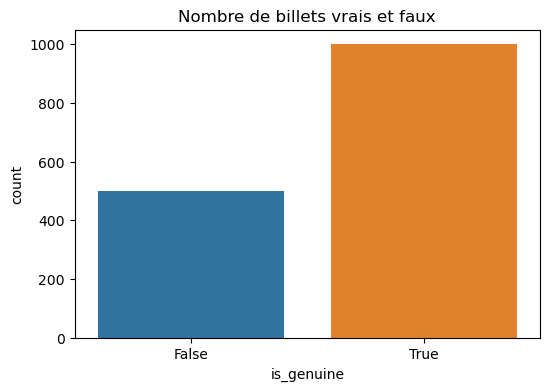

In [389]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_billets, x='is_genuine')
plt.title('Nombre de billets vrais et faux')
plt.show()

Nous avons 1000 Vrais billets & 500 Faux billets



**Les valeurs manquantes :**

In [390]:
# Affiche le nombre de valeurs manquantes
df_billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; > Création du DataFrame final
</h2>
</div>

Le jeu de données contient 1500 enregistrements et 7 variables :
> chaque enregistrement correspond à un billet 

> 1 variable qualitative : la variable is_genuine est de type booléen et indique si les billets sont vrais ou faux ;


> 6 variables quantitative : ces variables sont de type décimal et décrivent les dimensions des billets.


> Pas de doublons

> Il manque 37 valeurs à margin_low. Avant de mettre en place l'algorithme de détection, il faut d'abord traiter ces valeurs manquantes.


In [391]:
print("La variable margin_low compte",df_billets['margin_low'].isnull().sum(),"lignes avec des valeurs manquantes!")

La variable margin_low compte 37 lignes avec des valeurs manquantes!


# Analyse exploratoire des données


**Analyse des corrélations :**

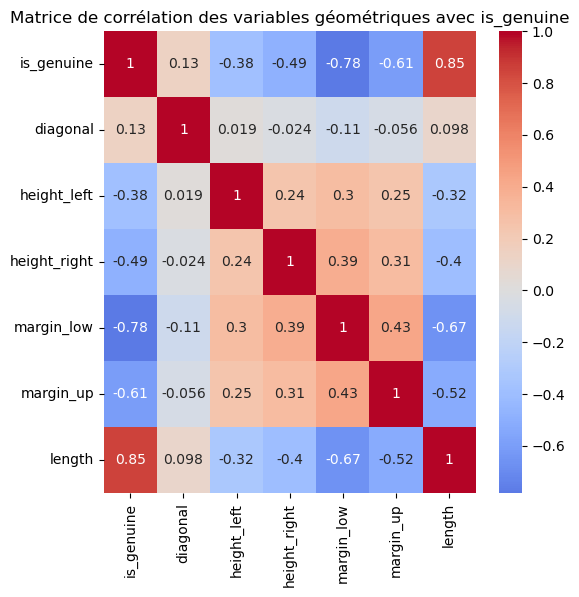

In [392]:
# Calcul de la matrice de corrélation, y compris 'is_genuine'
corr_matrix_with_is_genuine = df_billets.corr()

# Visualisation de la matrice de corrélation avec un heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix_with_is_genuine, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation des variables géométriques avec is_genuine')
plt.show()

>  Les deux variables quantitative les plus corréler sont 'length' et 'margin_low', elle sont corréler négativement !

> La variable margin_low est bien corrélée avec les autres variables à l'exception de diagonal.



> Les variables les plus corréler à 'is_genuine' dans l'odre décroissant :

       'length'

        'margin_low'

        'margin_up'

        'height_right'

        'height_left'

        'diagonal'



C:\Users\hicha\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


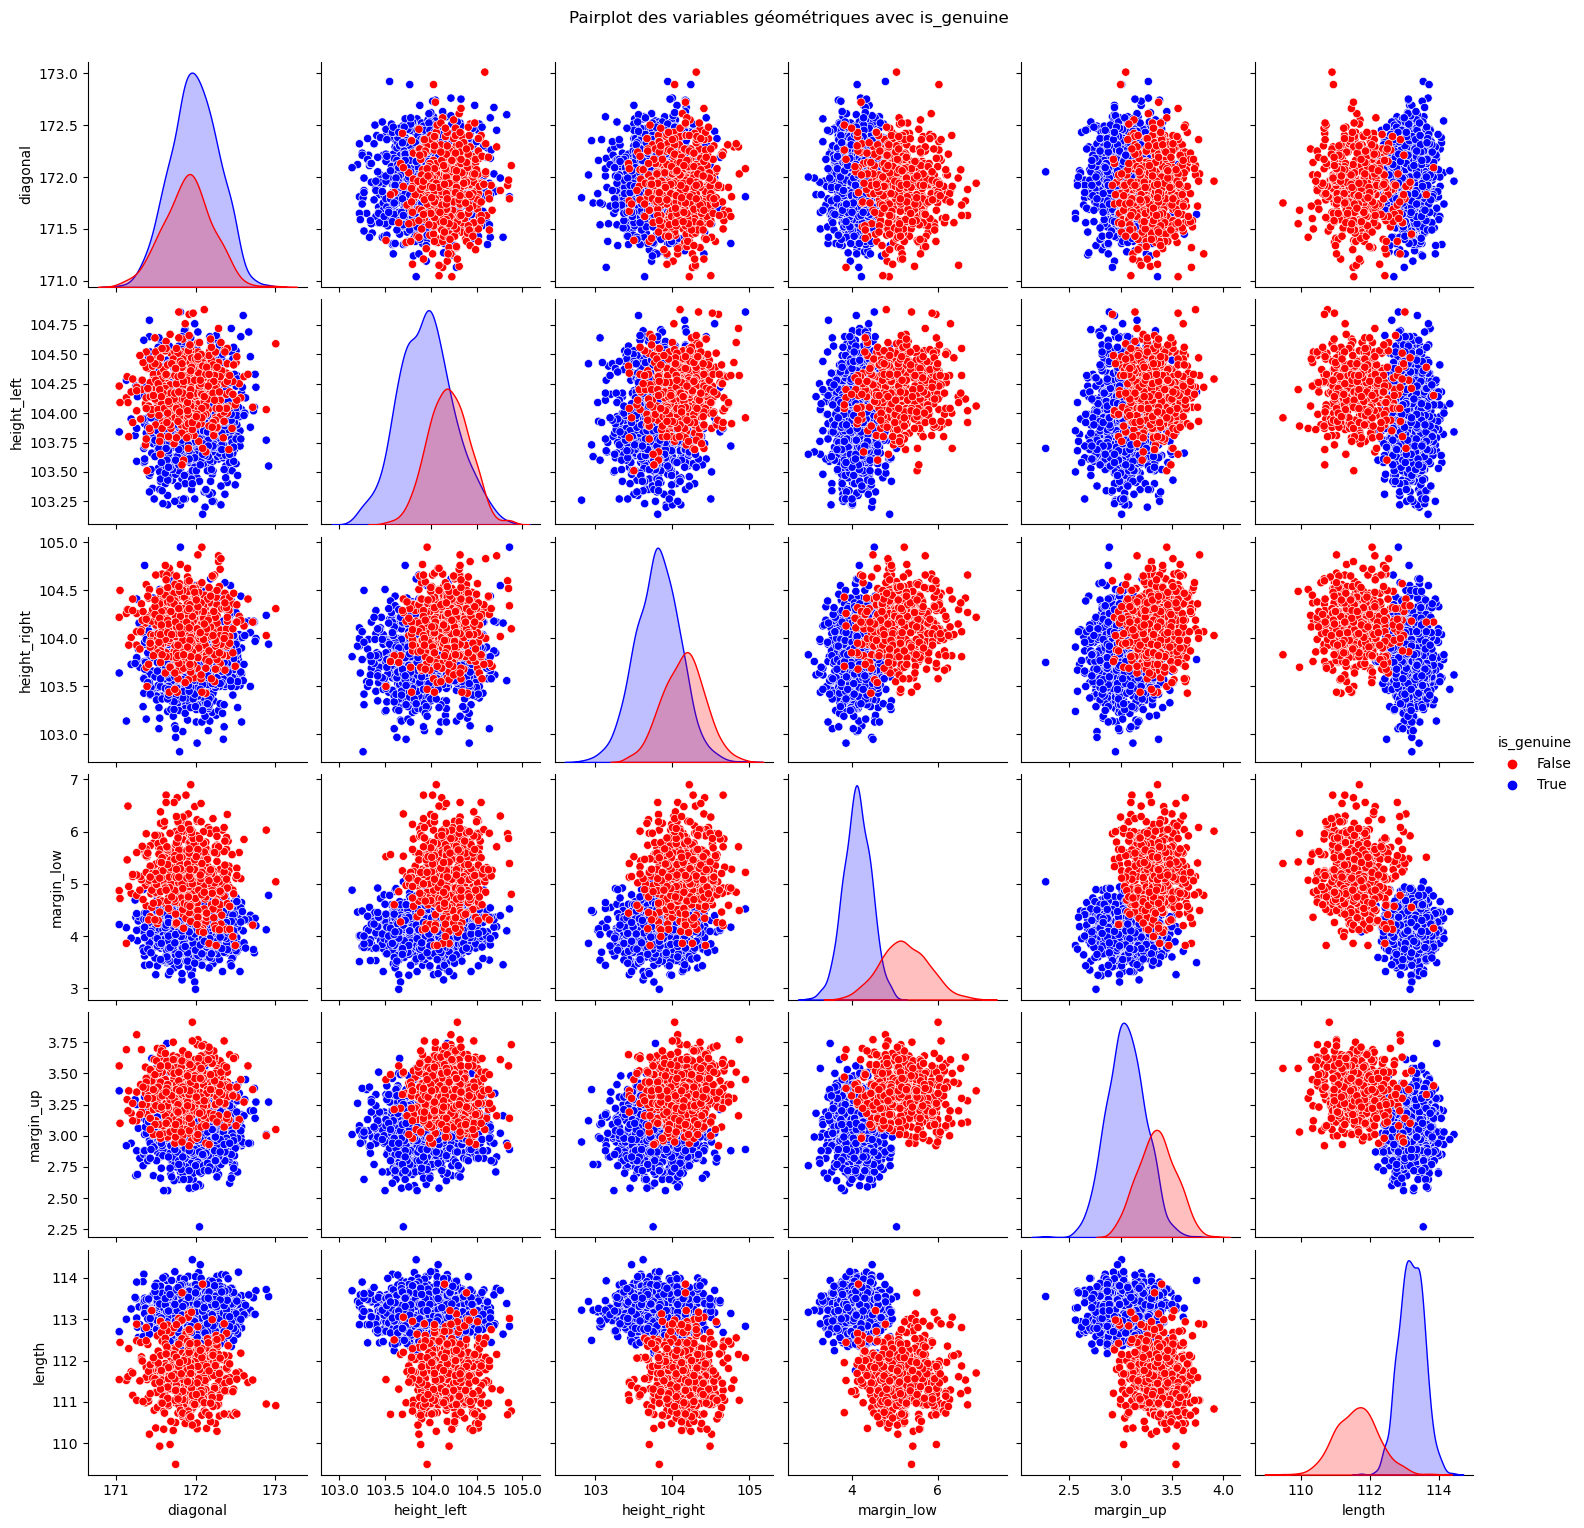

In [393]:
# Paires de graphiques de dispersion avec la variable 'is_genuine' comme hue
sns.pairplot(df_billets, hue='is_genuine', palette={True: 'blue', False: 'red'})
plt.suptitle('Pairplot des variables géométriques avec is_genuine', y=1.02)
plt.show()

Les 2 groupes sont le plus distinct sur la ligne de la variable 'length'



 On peut également tracer les boxplots pour visualiser la distribution des variables géométriques pour les deux groupes définis par la variable is_genuine (vrai ou faux). Les boxplots sont particulièrement utiles pour observer la répartition des données, les médianes, les quartiles et les éventuelles valeurs aberrantes pour chaque groupe.

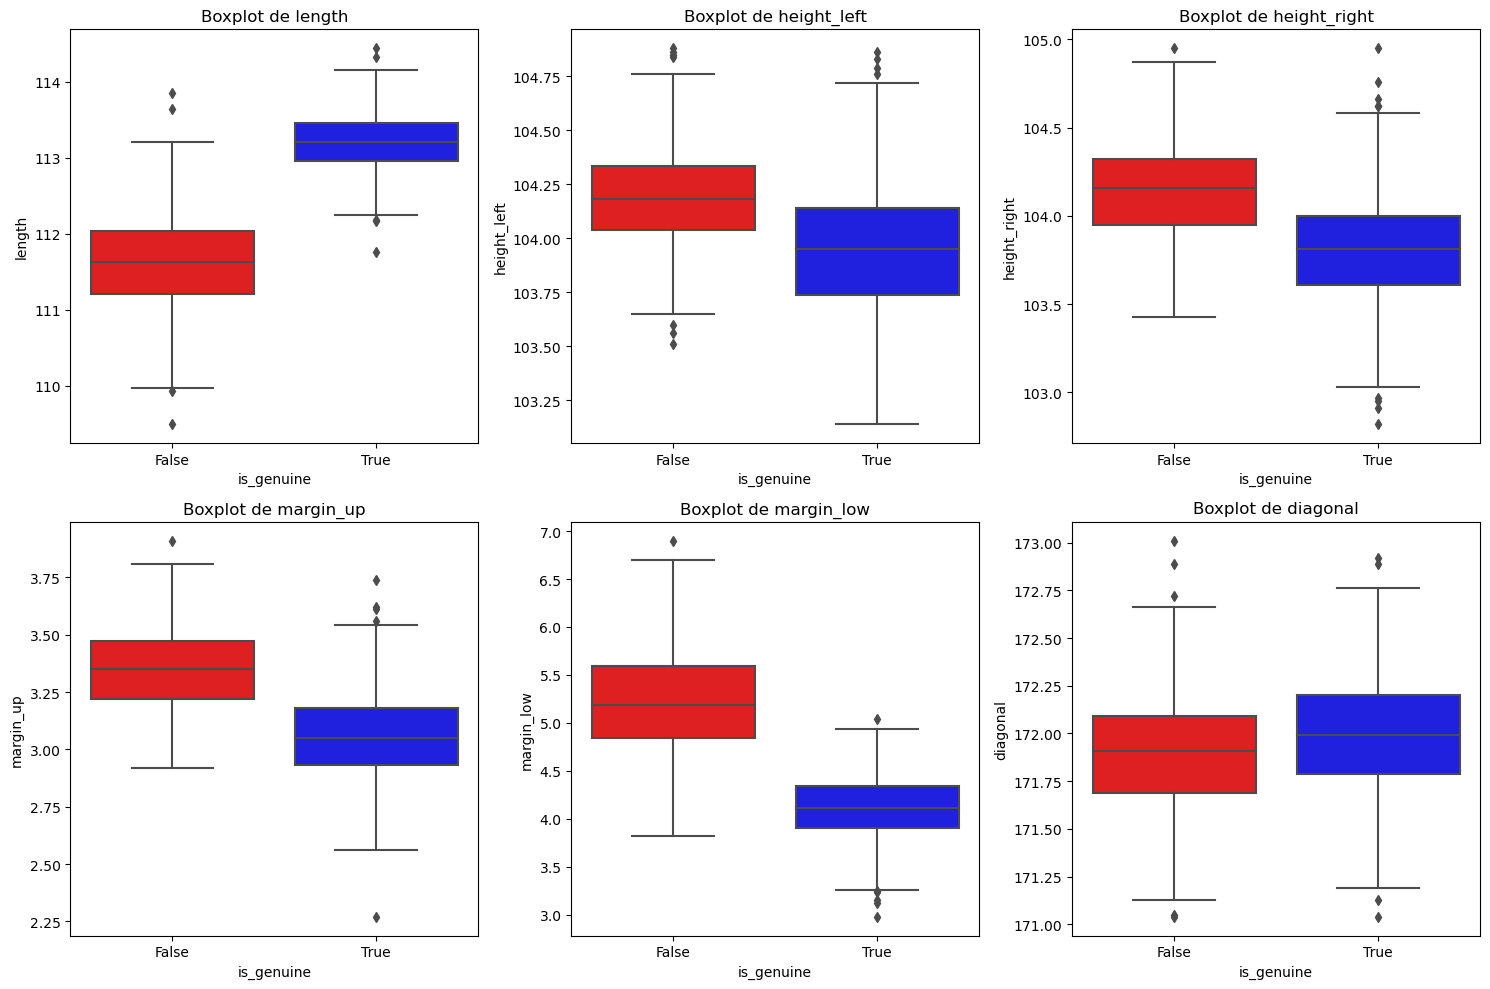

In [394]:
# Liste des variables géométriques
variables_geom = ['length', 'height_left', 'height_right', 'margin_up', 'margin_low', 'diagonal']

# Création des boxplots pour chaque variable géométrique
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables_geom, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='is_genuine', y=var, data=df_billets, palette={True: 'blue', False: 'red'})
    plt.title(f'Boxplot de {var}')
    plt.xlabel('is_genuine')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

> Les variables 'length' et 'margin_low' ont le plus de différence entre les vrais et les faux billets !

> Il semble que length et margin_low sont les variables les plus discriminantes entre les vrais et les faux billets



Pour visualiser plus en détail la différence entre les vrais et les faux billets pour les variables length et margin_low, vous pouvez utiliser des histogrammes 

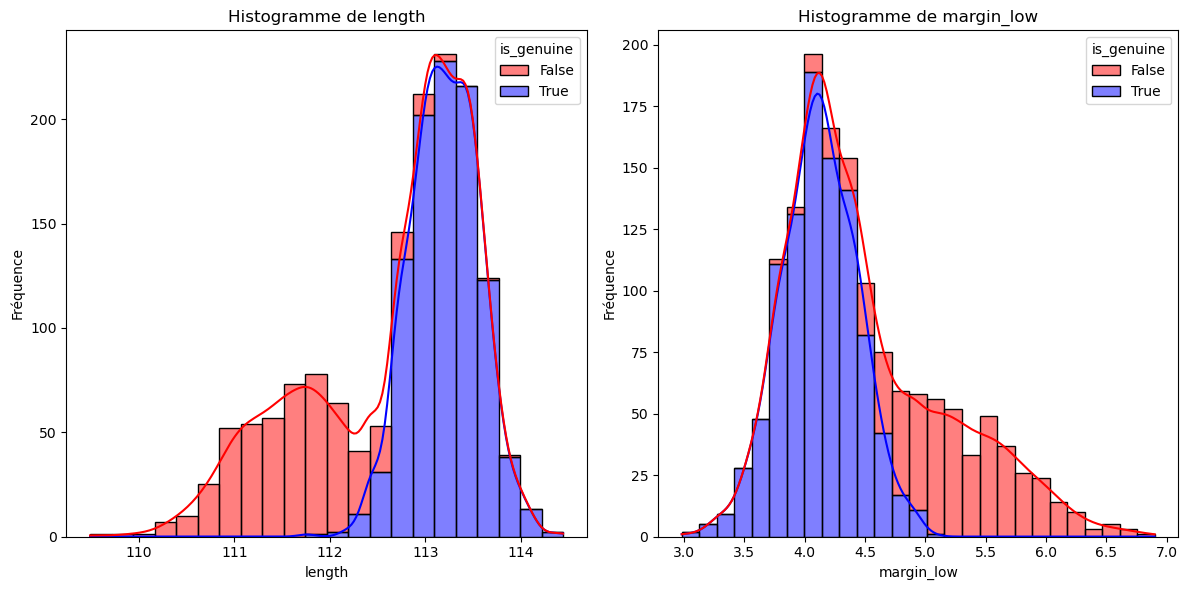

In [395]:
plt.figure(figsize=(12, 6))

# Histogramme pour 'length'
plt.subplot(1, 2, 1)
sns.histplot(data=df_billets, x='length', hue='is_genuine', multiple='stack', palette={True: 'blue', False: 'red'}, kde=True)
plt.title('Histogramme de length')
plt.xlabel('length')
plt.ylabel('Fréquence')

# Histogramme pour 'margin_low'
plt.subplot(1, 2, 2)
sns.histplot(data=df_billets, x='margin_low', hue='is_genuine', multiple='stack', palette={True: 'blue', False: 'red'}, kde=True)
plt.title('Histogramme de margin_low')
plt.xlabel('margin_low')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()


> Vrais billets : Une distribution concave signifie que les vraies caractéristiques des billets sont plus cohérentes et concentrées autour d'une valeur centrale.

> Faux billets : Une distribution plus étendue indique une plus grande variabilité dans les caractéristiques des faux billets.

> Ces différences observées dans les distributions de length et margin_low entre les vrais et les faux billets suggèrent effectivement que ces variables pourraient être des discriminants efficaces. 

**Traitement des valeurs manquantes :**


Dans le cadre de ce projet, on va utiliser la régression linéaire multiple pour prédir les valeurs manquantes. Le principe consiste à modéliser une variable dépendante, ici margin_low, grâce à une combinaison linéaire de variables explicatives indépendantes, ici diagonal, height_left, etc.. Le résultat de la régression permettra ensuite de prédire les valeurs manquantes de margin_low.

Avant de procéder à la régression linéaire, il est crucial de vérifier que les données satisfont les hypothèses sous-jacentes de la régression linéaire, telles que la multicolinéarité et la linéarité. Cela garantit que le modèle sera approprié et que les résultats seront interprétables. En effet, nous allons procéder comme suit :

> Vérification des hypothèses de base ( la multicolinéarité et la linéarité) avant d'appliquer la régression linéaire.

> Créer une copie du DataFrame sans valeurs manquantes.

> Séparer la variable dépendante des variables explicatives.

> Séparer les données en ensembles d'entraînement et de test.

> Effectuer la régression : entraînement du modèle sur les données d'entraînement.

> Évaluer le modèle: on l'applique aux données « test » puis on calcule une série d'indicateurs.

> Vérification des hypothèses sur le modèle entraîné (analyse des résidus, normalité, etc.).

> Imputation des valeurs manquantes à l'aide du modèle validé.

> Reconstitution du jeu de données complet pour la suite de notre analyse

**1. Vérification des Hypothèses de Base :**


**Linéarité :**

La linéarité entre chaque variable explicative et la variable dépendante peut être vérifiée à l'aide de scatter plots. Les scatter plots peuvent montrer une relation linéaire approximative.

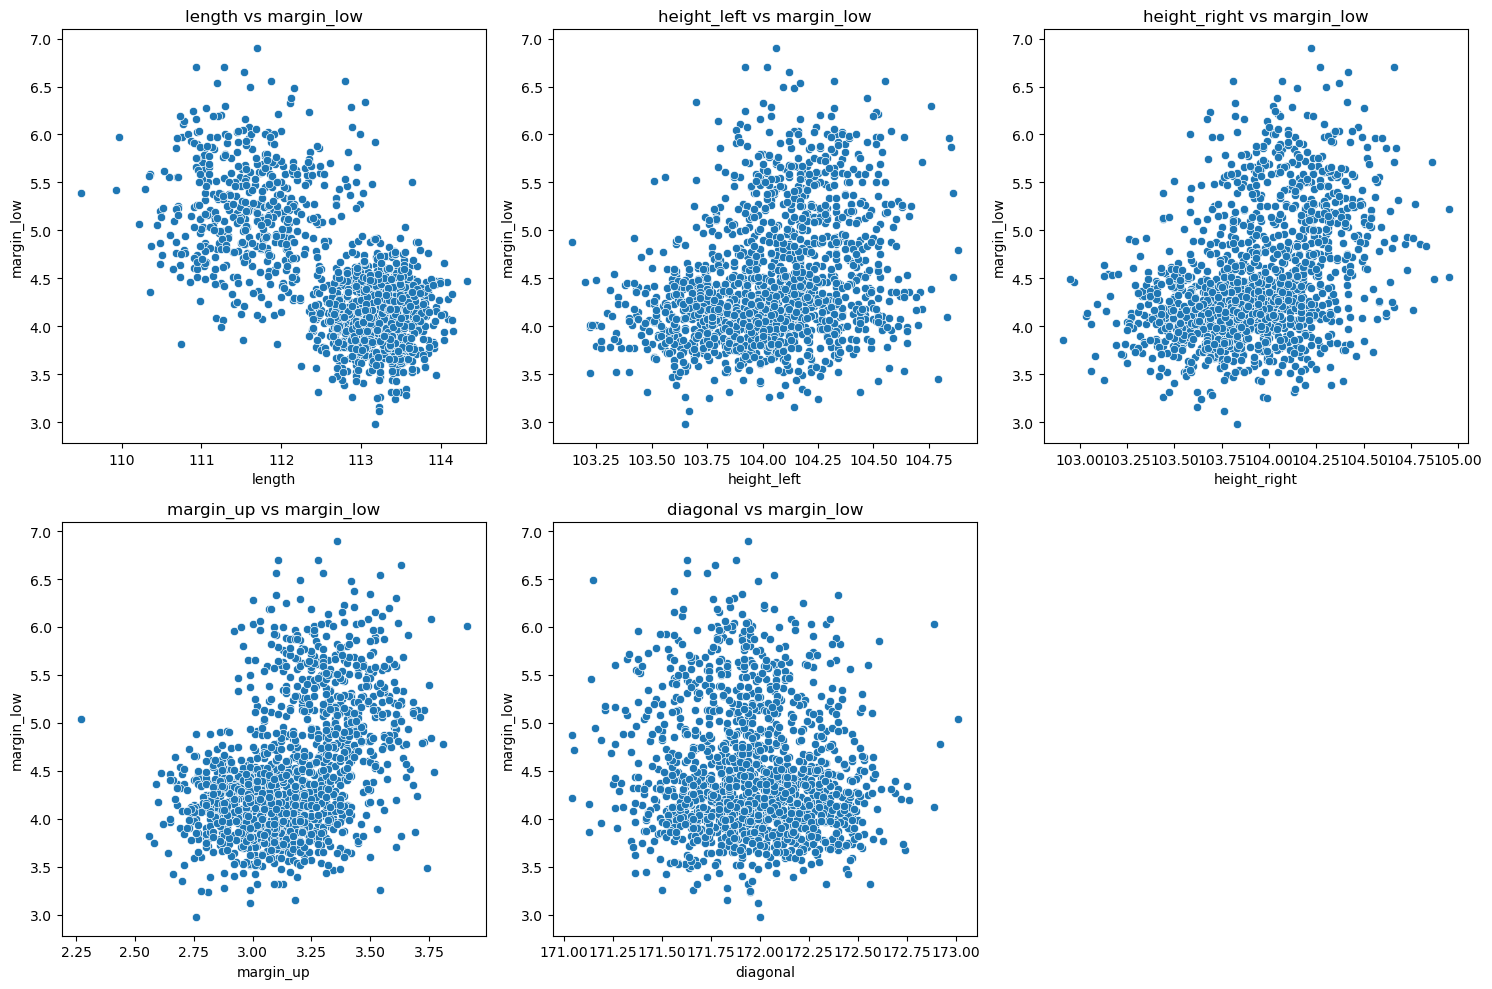

In [396]:
# Supposons que df_billets_sans_na soit le DataFrame sans valeurs manquantes : car les valeurs manquantes 
#peuvent fausser la visualisation des relations entre les variables
df_billets_sans_na = df_billets.dropna(subset=['margin_low'])

# Liste des variables explicatives
features = ['length', 'height_left', 'height_right', 'margin_up', 'diagonal']

# Nombre de variables explicatives
num_features = len(features)

# Définir le nombre de colonnes pour les subplots
n_cols = 3

# Calculer le nombre de lignes nécessaires
n_rows = (num_features + n_cols - 1) // n_cols

# Créer une figure pour les subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Tracer chaque scatter plot
for i, feature in enumerate(features):
    row = i // n_cols
    col = i % n_cols
    sns.scatterplot(x=df_billets_sans_na[feature], y=df_billets_sans_na['margin_low'], ax=axes[row, col])
    axes[row, col].set_title(f'{feature} vs margin_low')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('margin_low')

# Supprimer les axes vides si le nombre de sous-plots n'est pas complet
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

# Afficher les plots
plt.tight_layout()
plt.show()


les scatter plots ne montrent pas clairement une relation linéaire, donc nous allons effectuer le Rainbow test, qui est un test formel pour vérifier la linéarité. 

In [397]:
# Supposons que df_billets_sans_na soit le DataFrame sans valeurs manquantes
#df_billets_sans_na = df_billets.dropna(subset=['margin_low'])

# Liste des variables explicatives
features = ['length', 'height_left', 'height_right', 'margin_up', 'diagonal']

# Définir les variables explicatives (ajouter une constante pour l'interception)
X = sm.add_constant(df_billets_sans_na[features])

# Définir la variable dépendante
y = df_billets_sans_na['margin_low']

# Ajuster le modèle de régression linéaire
model = sm.OLS(y, X).fit()

# Effectuer le Rainbow Test
rainbow_statistic, rainbow_p_value = linear_rainbow(model)

# Afficher les résultats du Rainbow Test
print(f'Rainbow Statistic: {rainbow_statistic:.4f}')
print(f'P-value: {rainbow_p_value:.4f}')

# Interprétation du résultat
if rainbow_p_value > 0.05:
    print("Le test n'a pas rejeté l'hypothèse de linéarité (relation linéaire plausible).")
else:
    print("Le test a rejeté l'hypothèse de linéarité (relation non linéaire possible).")


Rainbow Statistic: 1.4409
P-value: 0.0000
Le test a rejeté l'hypothèse de linéarité (relation non linéaire possible).


Le test de Rainbow suggère que la relation n'est pas parfaitement linéaire, cependant nous alllons appliquer la régression linéaire et voire si le modèle linéaire fournit des résultats acceptables et est plus simple à interpréter. Donc  il peut être utile même avec des violations des hypothèses.

**Multicolinéarité :**

La multicolinéarité se réfère à la présence de corrélations élevées entre les variables explicatives dans un modèle de régression. Cela peut être évalué en calculant le Variance Inflation Factor (VIF) pour chaque variable explicative.

si VIF = 1 : pas de corrélation entre les variables explicatives ;

si 1 < VIF ≤ 5 : il y a une corrélation modérée mais ne nécessite pas forcément une attention particulière ;

si VIF > 5 : il y a une corrélation importante qui peut nuire au résultat de la régression.

In [398]:
# Supposons que df_billets soit le DataFrame complet avec les valeurs manquantes imputées.
# Liste des caractéristiques pour la régression
features = ['length', 'height_left', 'height_right', 'margin_up', 'diagonal']

# Créer un DataFrame pour le calcul du VIF
X = df_billets[features]
X = add_constant(X)  # Ajouter une constante pour le calcul du VIF

# Calculer le VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factor (VIF) pour chaque variable :")
print(vif_data)



Variance Inflation Factor (VIF) pour chaque variable :
        feature            VIF
0         const  591443.076346
1        length       1.574765
2   height_left       1.145295
3  height_right       1.229263
4     margin_up       1.403517
5      diagonal       1.012790


Toutes les valeurs sont proches de 1, il n'y a donc pas de problème de multicolinéarité.



**2.Créer une copie du DataFrame sans valeurs manquantes**

In [399]:
# Crée une copie du DataFrame sans valeurs manquantes
df_billets_sans_na = df_billets.loc[
    ~df_billets.isna().any(axis='columns')].copy()

# Affiche le nombre d'enregistrements 
print(f'Dimensions : {df_billets_sans_na.shape}')

# Vérifie si il y des valeurs manquantes
print(f'Valeur(s) manquante(s) : {df_billets_sans_na.isna().any().any()}')

Dimensions : (1463, 7)
Valeur(s) manquante(s) : False


**3.Séparer la variable dépendante des variables explicatives**

La variable dépendante doit ensuite être séparée des variables explicatives.


In [400]:
# Définit X et y
y = df_billets_sans_na['margin_low']
X = df_billets_sans_na.drop(columns=['is_genuine', 'margin_low'])

**4.Séparer les données en ensembles d'entraînement et de test**

Avant d'effectuer la régression, Les données sont séparées en :

une partie « train » sur laquelle sera entraîné le modèle ;

une partie « test » pour tester les résultats du modèle.

In [401]:
# Sépare les données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

**5.Effectuer la régression : entraînement du modèle sur les données d'entraînement**

In [402]:
# Effectue la régression
lr = LinearRegression()
lr = lr.fit(X_train, y_train)

**6.Évaluer le modèle: on l'applique aux données « test » puis on calcule une série d'indicateurs**

Pour évaluer le modèle, on l'applique aux données « test » puis on calcule une série d'indicateurs.



In [403]:
# Effectue la prédiction sur les données test
y_pred = lr.predict(X_test)

# Calcule et affiche les métriques
lr_metrics = ['r2', 'mse', 'rmse', 'mae']


# Calcule les métriques
r2 = lr.score(X_train, y_train)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
mae = metrics.mean_absolute_error(y_test, y_pred)

# Stocke les métriques dans une liste
lr_metrics_values = []
lr_metrics_values.extend([r2, mse, rmse, mae])

# Affiche les métriques
lr_metrics = ['r2', 'mse', 'rmse', 'mae']

for lr_metric, lr_metric_value in zip(lr_metrics, lr_metrics_values):
    print(f'{lr_metric.upper()} : \t{lr_metric_value:.6f}')


R2 : 	0.481499
MSE : 	0.232961
RMSE : 	0.482661
MAE : 	0.368762


Pour donner plus de sens aux métriques MSE, RMSE et MAE en tenant compte de l'échelle des données, nous pouvons les convertir en pourcentage par rapport à la moyenne des valeurs réelles de margin_low dans le jeu de test.

In [404]:

# Calcule la moyenne des valeurs réelles de margin_low dans le jeu de test
mean_y_test = np.mean(y_test)

# Calcule les métriques en pourcentage
mse_percentage = (mse / mean_y_test) * 100
rmse_percentage = (rmse / mean_y_test) * 100
mae_percentage = (mae / mean_y_test) * 100

# Affiche les métriques
print(f'R2 : \t{r2:.6f}')
print(f'MSE : \t{mse:.6f} ({mse_percentage:.2f}%)')
print(f'RMSE : \t{rmse:.6f} ({rmse_percentage:.2f}%)')
print(f'MAE : \t{mae:.6f} ({mae_percentage:.2f}%)')

R2 : 	0.481499
MSE : 	0.232961 (5.18%)
RMSE : 	0.482661 (10.74%)
MAE : 	0.368762 (8.21%)


> Le R² indique que 48.15% de la variance dans margin_low est expliquée par le modèle. Donc le modèle a une capacité raisonnable à expliquer la variance dans margin_low et cela suggère que le modèle est assez utile.

> Le MSE mesure la moyenne des carrés des erreurs entre les valeurs prédites par le modèle et les valeurs réelles. Plus le MSE est bas, meilleure est la qualité des prédictions. Dans notre cas, MSE proche de 0 ce qui est une bonne chose car c'est l'une des valeurs que l'on cherche à minimiser dans le cadre d'une régression.  Le pourcentage (5.18%) indique que cette erreur est environ 5.18% de la moyenne des valeurs réelles de margin_low.  Le pourcentage (8.21%) indique que cette erreur représente environ 8.21% de la moyenne des valeurs réelles de margin_low

> Les erreurs d'estimation (RMSE, MAE) sont relativement faibles, ce qui signifie que, en moyenne, les prédictions sont assez proches des valeurs réelles.

**7.Vérification des hypothèses sur le modèle entraîné (analyse des résidus, normalité, etc.)**

Après avoir entraîné le modèle, il faut vérifier plusieurs hypothèses en analysant les résidus qu'il faut donc calculer (pour s'assurer de la fiabilité du modèle)




In [405]:
# Calculer les résidus
residuals = y_test - y_pred

>  Hypothèse 1 : linéarité du modèle

La relation entre les variables explicatives et la variable cible doit être linéaire. Pour vérifier cela, on trace les résidus en fonction des valeurs prédites et on vérifie si on observe une relation linéaire.

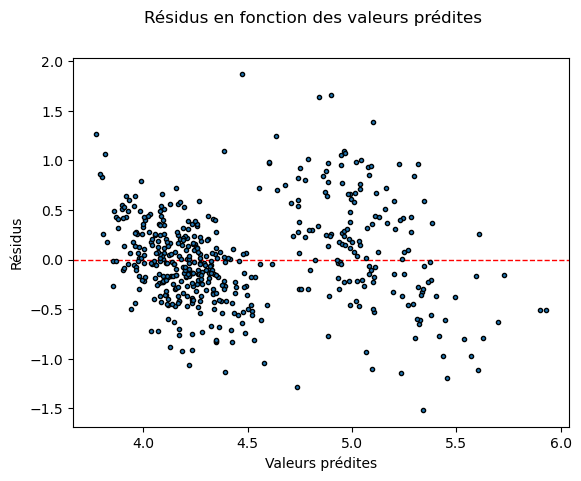

In [406]:
# Trace le graphique
fig, ax = plt.subplots()

ax.scatter(x=y_pred, y=residuals, marker='.', edgecolors='k')
ax.axhline(y=0, color='r', linestyle='--', linewidth=1, zorder=0)

ax.set_xlabel('Valeurs prédites')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction des valeurs prédites')

plt.show()

del fig, ax

On n'observe pas de relation linéaire!



> Hypothèse 2 : indépendance des résidus

Les résidus ne doivent pas être liés c’est-à-dire que la valeur d’un résidu ne doit pas nous permettre de connaître celui d’un autre. 

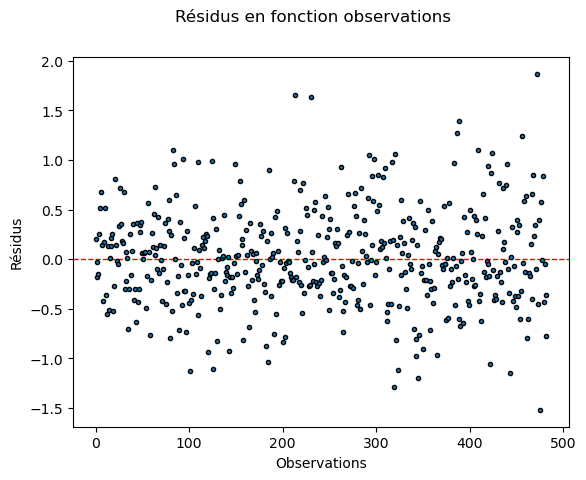

In [407]:
# Trace le graphique
fig, ax = plt.subplots()

ax.scatter(x=range(len(residuals)), y=residuals, marker='.',
           edgecolors='k')
ax.axhline(y=0, color='r', linestyle='--', linewidth=1, zorder=0)

ax.set_xlabel('Observations')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction observations')

plt.show()

del fig, ax

  Les résidus semblent répartis de manière aléatoire autour de 0. Pour confimer notre observation, Les statistiques descriptives des résidus peuvent fournir des informations importantes sur la distribution des résidus et aident à valider notre observation. 

In [408]:
mean_residuals = np.mean(residuals)
print(f"Mean of Residuals: {mean_residuals:.4f}")
std_residuals = np.std(residuals)
print(f"Standard Deviation of Residuals: {std_residuals:.4f}")


Mean of Residuals: 0.0111
Standard Deviation of Residuals: 0.4825


 La moyenne des résidus est très proche de zéro, ce qui est un bon signe. Cela indique que, en moyenne, les prédictions du modèle sont  correctes et bien équilibrées autour des valeurs réelles. Un écart-type de 0.4825 signifie que les erreurs de prédiction ont une certaine variabilité. 

> Hypothèse 3 : homoscédasticité


L'homoscédasticité significie que la variance des résidus est constante pour toutes les valeurs des variables explicatives. Nous avons constaté précédemment que les résidus étaient dispersés de manière relativement uniforme autour de 0 donc nous pourrions considèrer que l'homoscédasticité est satisfaite. Néanmoins, nous allons réaliser le test statistique de Breush-Pagan dont les hypothèses sont les suivantes :

H0 : l’homoscédasticité est présente si p-value > 5 % ;

H1 : l’homoscédasticité n’est pas présente si p-value < 5 %.

In [409]:
# Ajout de la constante à X_test (on suppose que X_test est l'équivalent de X_train dans ce contexte)
X_test_const = sm.add_constant(X_test)

# Réaliser le test de Breusch-Pagan pour l'homoscédasticité
bp_test = het_breuschpagan(residuals, X_test_const)

# Affichage de la p-value du test
print(f'p-value : {bp_test[1]:.3e}')

# Suppression de l'objet `bp_test` si vous n'avez plus besoin de lui
del bp_test

p-value : 1.214e-05


Contrairement aux observations, le test indique que l'homoscédasticité n'est pas présente.



> Hypothèse 4 : normalité des résidus


Les valeurs des résidus doivent suivre une loi normale. On trace la distribution des résidus.



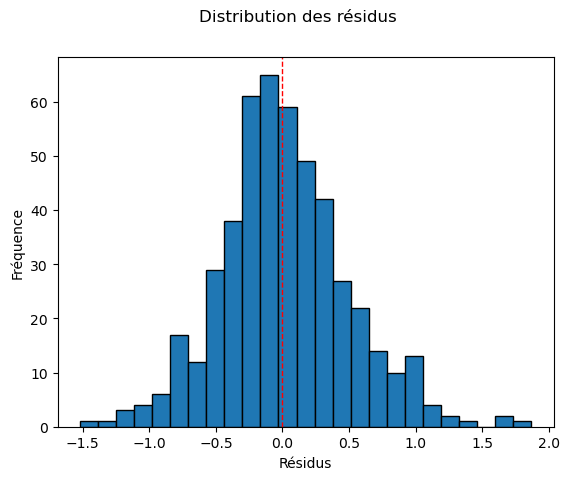

In [410]:
# Trace le graphique
fig, ax = plt.subplots()

ax.hist(x=residuals, bins=25, edgecolor='k')
ax.axvline(x=0, linestyle='--', linewidth=1, color='r')

ax.set_xlabel('Résidus')
ax.set_ylabel('Fréquence')
fig.suptitle('Distribution des résidus')

plt.show()

del fig, ax

On observe un décalage sur la gauche mais, à priori, la distribution proche de la normalité. Nous allons réaliser un test de Shapiro-Wilk ayant les hypothèses suivantes :

H0 : La normalité est vérifiée si p-value > 5 % ;
    
H1 : La normalité n'est pas vérifiée si p-value < 5 %.

In [411]:
from scipy.stats import shapiro

stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value > 0.05:
    print("Les résidus suivent une distribution normale (p > 0.05).")
else:
    print("Les résidus ne suivent pas une distribution normale (p <= 0.05).")


Shapiro-Wilk Test Statistic: 0.9896
P-Value: 0.0017
Les résidus ne suivent pas une distribution normale (p <= 0.05).


Là aussi, contrairement aux observations le test n'est pas concluant.



> Hypothèse 5 : pas de colinéarité


Les variables explicatives ne doivent pas être fortement corrélées entre elles, or, nous avions observé quelques coefficients de corrélation assez élevés. Afin de déterminer si cette hypothèse est validée, nous allons calculer le « VIF » (facteur d'inflation de variance) pour chaque variable explicative :

si VIF = 1 : pas de corrélation entre les variables explicatives ;

si 1 < VIF ≤ 5 : il y a une corrélation modérée mais ne nécessite pas forcément une attention particulière ;

si VIF > 5 : il y a une corrélation importante qui peut nuire au résultat de la régression.

In [412]:
# Calcule le VIF pour chaque variable explicative considérée dépendante
for column in X_train.columns:
    y_vif = X_train[column]
    X_vif = X_train.drop(columns=column)
    lr_vif = LinearRegression().fit(X_vif, y_vif)
    r2_vif = lr_vif.score(X_vif, y_vif)
    vif = 1 / (1 - r2_vif)
    print(f'{column} : \t{vif:.3f}')

del column, y_vif, X_vif, lr_vif, r2_vif, vif

diagonal : 	1.006
height_left : 	1.167
height_right : 	1.206
margin_up : 	1.451
length : 	1.597


Toutes les valeurs sont proches de 1, il n'y a donc pas de problème de colinéarité.



Même si certaines hypothèses sont violées, il est possible que la régression linéaire donne encore des résultats corrects.

**8.Reconstituer le Jeu de Données Complet**

Après la prédiction des valeurs manquantes des enregistrements incomplets, on reconstitue le jeu de données complet pour la suite de notre analyse.

In [413]:
#Prédire les valeurs manquantes et reconstituer le DataFrame
# Copie les enregistrements contenant les valeurs manquantes
df_billets_na = df_billets[df_billets['margin_low'].isna()].copy()

# Prédit les valeurs manquantes grâce au modèle
df_billets_na['margin_low'] = lr.predict(df_billets_na[X.columns])

# Concatène les enregistrements avec et sans valeurs manquantes
df_billets_complet = pd.concat([df_billets_sans_na, df_billets_na]).sort_index()

# Nettoyage des variables intermédiaires
#del df_billets_sans_na, df_billets_na, X, y, X_train, y_train, X_test, y_test, y_pred, lr

# Afficher le DataFrame avec les valeurs imputées
print("\nDataFrame avec les valeurs imputées :")
print(df_billets_complet)


DataFrame avec les valeurs imputées :
      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   



In [414]:
df_billets.shape

(1500, 7)

In [415]:
# Affichez le nombre de valeurs manquantes pour chaque colonne
missing_values = df_billets_complet.isna().sum()
if missing_values.any():
    print("Valeurs manquantes restantes par colonne :")
    print(missing_values)
else:
    print("Il n'y a pas de valeurs manquantes dans le DataFrame.")

Il n'y a pas de valeurs manquantes dans le DataFrame.


# Construction de l'algorithme de détection

## Prétraitement des données 

Pour préparer la colonne is_genuine pour une régression logistique, nous devons la convertir en format numérique, car les modèles de régression logistique nécessitent des entrées numériques. La colonne is_genuine contient des valeurs booléennes (True/False), qu'on peut  transformer en valeurs numériques(0 et1).

In [416]:
# Convertir la colonne 'is_genuine' en numérique (True -> 1, False -> 0)
df_billets['is_genuine'] = df_billets_complet['is_genuine'].astype(int)
df_billets.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16


Puis on définit les variables explicatives et la cible et on sépare les données en entrainement et en test.


In [417]:
# Définir les variables explicatives (X) et la variable cible (y)
X = df_billets_complet.drop(columns=['is_genuine'])  # Variables explicatives
y = df_billets_complet['is_genuine']  # Variable cible


In [418]:
# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [419]:
print('X_train :', len(X_train), 'lignes',
    '\ny_train :', len(y_train), 'lignes',
    '\nX_test :', len(X_test), 'lignes',
    '\ny_test :', len(y_test), 'lignes')

X_train : 1005 lignes 
y_train : 1005 lignes 
X_test : 495 lignes 
y_test : 495 lignes


> 2/3 des données pour l'entrainement

> 1/3 des données pour le test

## Méthode 1 : régression logistique classique 

La régression logistique est une méthode statistique utilisée pour :
> Modéliser la relation entre une variable dépendante binaire (dichotomique) et une ou plusieurs variables indépendantes (prédicteurs). 


> Contrairement à la régression linéaire, qui prédit une valeur continue, la régression logistique prédit la probabilité qu'un événement particulier se produise (par exemple, succès/échec, oui/non).

Vue que Les hyperparamètres jouent un rôle crucial dans la configuration et la performance des modèles de machine learning (les bons hyperparamètres permettent d'optimiser la performance du modèle). Ici, pour notre cas de régression logistique nous allons procéder à tester plusieurs valeurs des deux hyperparamètres (les coefficient de régularisation 'C' et Le solver) pour la mise en oeuvre de la validation croisée et la recherche sur grille des hyperparamètres.

Ainsi, pour mieux comprendre les mécanismes sous-jacents de l'optimisation de ces hyperparamètres l'application de cette méthode sur notre jeu de données elle va être effectuée en deux grande étapes :
> Etape 1 : Recherche manuelle (sans optimisation) : c'est-à-dire, on procéde à la recherche sur grille et à la validation croisée manuellement .

> Etape 2 : Recherche automatisée ( optimisation avec GridSearchCV) : c'est-à-dire, la validation croisée et recherche sur grille sont réalisés explicitement.

**Etape 1 :**  sans optimisation

Pour la réalisation de cette étape nous allons suivre l'enchainement suivantes : 

1. Initilisaton des plis de la validation coisée

2. Définition de la grille des hyperparamètres ( ici le solver et le coefficient de régularisation)

3. Parcourir toutes les combinaisons possibles via des boucles dont (sur les données d'entrainement) :  

  > On entraîne le modèle
  
  > On fait des prédictions
  
  > On évalue le modèle par différentes métriques (matrice de confusion, accuracy, precision, recall, f1)  
  
4. Création d'une fonction de comparaison entre les métriques de performance des différentes combinaisons évaluées et  choix de la meuilleure combinaison d'hyperparamètres.

5. Appliquer et évaluer le modèle (avec la meuilleure combinaison choisit précidément ) sur les données de test.

In [420]:
# Initialiser la validation croisée : validation croisée à 5 plis
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [421]:
# Définir la grille d'hyperparamètres
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

In [ ]:
results = []  # initialiser une liste vide qui sera utilisée pour stocker les performances de chaque combinaison d'hyperparamètres

# Boucle sur les combinaisons d'hyperparamètres
for C in param_grid['C']:
    for solver in param_grid['solver']:
        fold_accuracies = []
        fold_confusions = []
        fold_reports = []

        # Boucle sur les plis de validation croisée
        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            # Créer et entraîner le modèle
            model_log_reg = LogisticRegression(C=C, solver=solver, max_iter=1000)
            model_log_reg.fit(X_train_fold, y_train_fold)

            # Faire des prédictions et évaluer le modèle
            y_pred = model_log_reg.predict(X_val_fold)
            accuracy = accuracy_score(y_val_fold, y_pred)
            report = classification_report(y_val_fold, y_pred, output_dict=True)
            confusion = confusion_matrix(y_val_fold, y_pred)
            
            fold_accuracies.append(accuracy)
            fold_confusions.append(confusion)
            fold_reports.append(report)

        # Calculer la précision moyenne pour cette combinaison d'hyperparamètres
        mean_accuracy = np.mean(fold_accuracies)
        mean_confusion = np.rint(np.mean(fold_confusions, axis=0)).astype(int)
        avg_precision = np.mean([rep['weighted avg']['precision'] for rep in fold_reports])
        avg_recall = np.mean([rep['weighted avg']['recall'] for rep in fold_reports])
        avg_f1 = np.mean([rep['weighted avg']['f1-score'] for rep in fold_reports])

        current_result = {
            'C': C,
            'solver': solver,
            'mean_accuracy': mean_accuracy,
            'mean_confusion': mean_confusion,
            'avg_precision': avg_precision,
            'avg_recall': avg_recall,
            'avg_f1': avg_f1
        }
        
        results.append(current_result)
        
        # Afficher la combinaison actuelle et ses performances
        print(f"Combinaison actuelle : C={C}, solver={solver}:")
        print(f"  mean_accuracy: {mean_accuracy:.4f}")
        print(f"  mean_confusion: \n{mean_confusion}")
        print(f"  avg_precision: {avg_precision:.4f}")
        print(f"  avg_recall: {avg_recall:.4f}")
        print(f"  avg_f1: {avg_f1:.4f}")
        print("-" * 50)


Combinaison actuelle : C=0.01, solver=liblinear:
  mean_accuracy: 0.9582
  mean_confusion: 
[[ 57   8]
 [  0 136]]
  avg_precision: 0.9607
  avg_recall: 0.9582
  avg_f1: 0.9574
--------------------------------------------------
Combinaison actuelle : C=0.01, solver=saga:
  mean_accuracy: 0.9552
  mean_confusion: 
[[ 56   9]
 [  0 136]]
  avg_precision: 0.9581
  avg_recall: 0.9552
  avg_f1: 0.9542
--------------------------------------------------
Combinaison actuelle : C=0.1, solver=liblinear:
  mean_accuracy: 0.9831
  mean_confusion: 
[[ 62   3]
 [  0 135]]
  avg_precision: 0.9834
  avg_recall: 0.9831
  avg_f1: 0.9830
--------------------------------------------------


C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Combinaison actuelle : C=0.1, solver=saga:
  mean_accuracy: 0.9811
  mean_confusion: 
[[ 62   4]
 [  0 136]]
  avg_precision: 0.9816
  avg_recall: 0.9811
  avg_f1: 0.9809
--------------------------------------------------
Combinaison actuelle : C=1, solver=liblinear:
  mean_accuracy: 0.9881
  mean_confusion: 
[[ 64   1]
 [  1 135]]
  avg_precision: 0.9882
  avg_recall: 0.9881
  avg_f1: 0.9881
--------------------------------------------------


C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Combinaison actuelle : C=1, solver=saga:
  mean_accuracy: 0.9821
  mean_confusion: 
[[ 62   3]
 [  0 136]]
  avg_precision: 0.9825
  avg_recall: 0.9821
  avg_f1: 0.9819
--------------------------------------------------
Combinaison actuelle : C=10, solver=liblinear:
  mean_accuracy: 0.9891
  mean_confusion: 
[[ 64   1]
 [  1 135]]
  avg_precision: 0.9891
  avg_recall: 0.9891
  avg_f1: 0.9891
--------------------------------------------------


C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hicha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Combinaison actuelle : C=10, solver=saga:
  mean_accuracy: 0.9821
  mean_confusion: 
[[ 62   3]
 [  0 136]]
  avg_precision: 0.9825
  avg_recall: 0.9821
  avg_f1: 0.9819
--------------------------------------------------
Combinaison actuelle : C=100, solver=liblinear:
  mean_accuracy: 0.9861
  mean_confusion: 
[[ 63   2]
 [  1 135]]
  avg_precision: 0.9862
  avg_recall: 0.9861
  avg_f1: 0.9860
--------------------------------------------------


Maintenat nous allons procéder à la création de la fonction qui nous permettent de comparer ces différents combinaisons pour choisir la meuilleure combinaison de coeffient de corrélation et solver pour l'applique au final sur les données de test qu'on a fixé dés le début.

Il est important que l'algorithme soit plus précis sur la détection des faux billets que sur celle des vrais billets : il est moins problématique de détecter un billet authentique comme étant faux que l'inverse. Il faut maximiser la précision de la détection des faux billets (minimiser les Faux Négatifs et les Faux Positifs pour les faux billets), il est donc crucial d'ajuster les pondérations pour accorder plus de poids aux métriques qui évaluent la capacité du modèle à identifier les faux billets dans cette fonction de comparaison pour refléter cette priorité.

c'est-à-dire le rappel et le F1-Score. La précision est importante mais pas aussi cruciale dans ce contexte, tandis que l'accuracy globale pourrait être moins pertinente.

In [ ]:
# Fonction de comparaison basée sur plusieurs métriques
def evaluate_combination(result):
    return (
        
        result['avg_recall'] * 0.5     +  # Poids 50% pour le rappel, car il est crucial pour détecter les faux billets
        result['avg_f1'] * 0.3 +         # Poids 30% pour le F1-score, car il équilibre la précision et le rappel
        result['mean_accuracy'] * 0.1 +  # Poids 10% pour la précision globale, moins pertinent dans ce contexte
        result['avg_precision'] * 0.1   # Poids 10% pour la précision, qui est moins critique mais encore importante

    )

# Trouver la meilleure combinaison d'hyperparamètres basée sur la fonction de comparaison
best_result = max(results, key=evaluate_combination)

# Afficher la meilleure combinaison d'hyperparamètres et les scores associés
print("Meilleure combinaison d'hyperparamètres :")
print("C =", best_result['C'])
print("solver =", best_result['solver'])

print("Matrice de confusion moyenne :\n", best_result['mean_confusion'])
print("Précision moyenne :", best_result['avg_precision'])
print("Rappel moyen :", best_result['avg_recall'])
print("F1-Score moyen :", best_result['avg_f1'])
print("Accuracy moyenne :", best_result['mean_accuracy'])


La matrice de confusion permet de mieux décrire les performances du modèle.

In [ ]:

# Extraire les valeurs de la matrice de confusion
TN, FP = mean_confusion[0]
FN, TP = mean_confusion[1]


# Tracer la matrice de confusion moyenne avec heatmap  pour la meilleure combinaison

plt.figure(figsize=(8, 6))
ax = sns.heatmap(mean_confusion, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])

# Annoter chaque cellule avec les étiquettes spécifiques
labels = np.array([['Vrais Négatifs\n(TN)', 'Faux Positifs\n(FP)'], ['Faux Négatifs\n(FN)', 'Vrais Positifs\n(TP)']])
for i in range(mean_confusion.shape[0]):
    for j in range(mean_confusion.shape[1]):
        ax.text(j, i + 0.2, labels[i, j], horizontalalignment='left', verticalalignment='center', color='black', fontsize=9, alpha=0.6)

plt.xlabel('Predected label')
plt.ylabel('True label')
plt.title('Matrice de Confusion Moyenne pour la Meilleure Combinaison d\'Hyperparamètres')
plt.show()

# Calculer les pourcentages
total = TN + FP + FN + TP
percent_TN = (TN / total) * 100
percent_FP = (FP / total) * 100
percent_FN = (FN / total) * 100
percent_TP = (TP / total) * 100

# Afficher les interprétations
print(f"\nInterprétation de la matrice de confusion :")
print(f"Vrais Négatifs (True Negatives, TN) : {TN} ({percent_TN:.2f}%) faux billets correctement identifiés comme faux.")
print(f"Faux Positifs (False Positives, FP) : {FP} ({percent_FP:.2f}%) vrais billets incorrectement identifiés comme faux.")
print(f"Faux Négatifs (False Negatives, FN) : {FN} ({percent_FN:.2f}%) faux billets incorrectement identifiés comme vrais.")
print(f"Vrais Positifs (True Positives, TP) : {TP} ({percent_TP:.2f}%) vrais billets correctement identifiés comme vrais.\n")
 


**Évaluation finale du Modèle sur le Jeu de Données de Test :**


In [ ]:
# Réentraîner le modèle avec les meilleurs hyperparamètres
best_model = LogisticRegression(C=10, solver='liblinear', max_iter=1000)
best_model.fit(X_train, y_train)

# Faire des prédictions sur le jeu de données de test
y_test_pred = best_model.predict(X_test)

# Évaluer la performance sur le jeu de données de test
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Afficher les résultats de performance
print("Performance sur le jeu de données de test:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Précision : {precision:.4f}")
print(f"Rappel : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print("Matrice de confusion :")
print(conf_matrix)


# Tracer la matrice de confusion moyenne avec heatmap  pour la meilleure combinaison

plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])

# Annoter chaque cellule avec les étiquettes spécifiques
labels = np.array([['Vrais Négatifs\n(TN)', 'Faux Positifs\n(FP)'], ['Faux Négatifs\n(FN)', 'Vrais Positifs\n(TP)']])
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i + 0.2, labels[i, j], horizontalalignment='left', verticalalignment='center', color='black', fontsize=9, alpha=0.6)

plt.xlabel('Label Prédit')
plt.ylabel('Label Réel')
plt.title('Matrice de Confusion pour la Meilleure Combinaison d\'Hyperparamètres')
plt.show()


# Calcul des pourcentages
total = conf_matrix.sum()
percentages = (conf_matrix / total * 100).round(1)

# Extraire les valeurs
TN, FP = conf_matrix[0]
FN, TP = conf_matrix[1]

# Extraire les pourcentages
percentages_TN, percentages_FP = percentages[0]
percentages_FN, percentages_TP = percentages[1]


print(f"\nInterprétation de la matrice de confusion :")
print(f"Vrais Négatifs (True Negatives, TN) : {TN} ({percentages_TN}%) faux billets correctement identifiés comme faux.")
print(f"Faux Positifs (False Positives, FP) : {FP} ({percentages_FP}%) vrais billets incorrectement identifiés comme faux.")
print(f"Faux Négatifs (False Negatives, FN) : {FN} ({percentages_FN}%) faux billets incorrectement identifiés comme vrais.")
print(f"Vrais Positifs (True Positives, TP) : {TP} ({percentages_TP}%) vrais billets correctement identifiés comme vrais.\n")


Notre modèle semble être très performant dans la détection des faux billets avec un très faible taux de faux positifs et un excellent taux de vrais positifs. Il est également efficace pour détecter la majorité des faux billets, avec un faible taux de faux négatifs.


**Etape 2 :**  avec optimisation (GridSearchCV)

Essayons d'améliorer notre modèle en optimisant le choix des paramètres de la régression grâce à GridSearchCV qui consiste à simplifier et automatiser plusieurs étapes que nous avez déja effectuées manuellement.

La fonction evaluate_combination que nous avons créée avant est conçue pour donner plus de poids aux métriques qui sont les plus pertinentes, en particulier le rappel, qui est crucial pour détecter les faux billets.

Pour intégrer cette logique à GridSearchCV, nous allons créer une fonction de scoring personnalisée qui utilise les mêmes principes. Cependant, au lieu de passer par GridSearchCV avec une simple métrique comme l'accuracy, nous allons écrire une fonction de scoring qui reproduit la logique de evaluate_combination et l'utiliser comme critère pour sélectionner les meilleurs hyperparamètres.

Donc, elle prend en entrée les prédictions et les étiquettes réelles, puis elle calcule les différentes métriques, les Combine selon les poids que nous avons déja définis. Donc l'enchainement des étapes que nous allons réalisé est le suivant : 


> Fonction 'function_score' : Nous allons intégré notre logique de pondération des métriques dans une fonction de scoring personnalisée.

> GridSearchCV : Sélectionne automatiquement la meilleure combinaison d'hyperparamètres en fonction de cette fonction de scoring, ce qui respecte nos priorités de performance.

> Évaluation Finale : Le modèle sélectionné est évalué sur le jeu de test avec des métriques complètes, incluant une matrice de confusion détaillée et une interprétation des résultats.

In [ ]:
# Fonction de scoring personnalisée basée sur la fonction de comparaison utilisée précédemment
def function_score(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    # Appliquer les poids que vous avez définis
    score = (recall * 0.5) + (f1 * 0.3) + (accuracy * 0.1) + (precision * 0.1)
    return score

Par la suite GridSearchCV est configuré pour utiliser cette fonction de scoring personnalisée

In [ ]:
# Créer un objet scorer à partir de la fonction de scoring personnalisée
scorer = make_scorer(function_score, greater_is_better=True)


# Configurer GridSearchCV pour utiliser notre scorer personnalisé
grid_search = GridSearchCV(estimator=model_log_reg, param_grid=param_grid, cv=5, scoring=scorer)

# Entraîner GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleure combinaison d'hyperparamètres :", grid_search.best_params_)



Une fois les meilleurs hyperparamètres sélectionnés, le modèle est évalué sur le jeu de test avec les métriques habituelles : accuracy, precision, recall, f1_score, ainsi qu'une matrice de confusion.

In [ ]:
# Utiliser le meilleur modèle pour faire des prédictions sur le jeu de test
best_model_log_reg = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)

# Calculer les métriques de performance
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Afficher les résultats de performance
print("Performance sur le jeu de données de test:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Précision : {precision:.4f}")
print(f"Rappel : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print("Matrice de confusion :")
print(conf_matrix)

# Affichage détaillé avec la matrice de confusion

plt.figure(figsize=(9, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Faux', 'Vrais'], yticklabels=['Faux', 'Vrais'])

# Annoter chaque cellule avec des étiquettes spécifiques
labels = np.array([['Vrais Négatifs\n(TN)', 'Faux Positifs\n(FP)'], ['Faux Négatifs\n(FN)', 'Vrais Positifs\n(TP)']])
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]): 
        ax.text(j, i + 0.2, labels[i, j], color='black', fontsize=12, alpha=0.6)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de Confusion pour le Meilleur Modèle')
plt.show()

# Interprétation des résultats
TN, FP = conf_matrix[0]
FN, TP = conf_matrix[1]
total = TN + FP + FN + TP

print(f"\nInterprétation de la matrice de confusion :")
print(f"Vrais Négatifs (True Negatives, TN) : {TN} ({TN/total:.1%}) faux billets correctement identifiés comme faux.")
print(f"Faux Positifs (False Positives, FP) : {FP} ({FP/total:.1%}) vrais billets incorrectement identifiés comme faux.")
print(f"Faux Négatifs (False Negatives, FN) : {FN} ({FN/total:.1%}) faux billets incorrectement identifiés comme vrais.")
print(f"Vrais Positifs (True Positives, TP) : {TP} ({TP/total:.1%}) vrais billets correctement identifiés comme vrais.\n")


**Comparaison des deux approches :**

> Les résultats sont identiques, cela montre que GridSearchCV a correctement exploré l'espace des hyperparamètres et a confirmé que les meilleurs paramètres trouvés manuellement sont effectivement les meilleurs.

> La stabilité des résultats suggère que votre modèle est robuste et que les hyperparamètres n'ont pas un impact significatif sur la performance

Un dernier point consiste à tracer la courbe ROC (Receiver Operating Characteristic) qui est un outil très utile pour évaluer les performances d'un modèle de classification binaire, en particulier pour comprendre le compromis entre le taux de vrais positifs (rappel) et le taux de faux positifs.  L'aire sous la courbe ROC mesure la qualité globale de notre modèle. Plus l'AUC est proche de 1, meilleur est notre modèle.

In [ ]:
# Standardisation des caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Obtenir les probabilités prédites pour la classe positive (régression logistique)
y_scores_log_reg = best_model_log_reg.predict_proba(X_test_scaled)[:, 1]

# Calculer la courbe ROC et l'AUC pour la régression logistique
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_scores_log_reg)
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# Tracer la courbe ROC pour la régression logistique
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Regression Logistique (AUC = {auc_log_reg:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - Régression Logistique')
plt.legend(loc='lower right')
plt.show()


Le modèle quasiment parfait avec une aire sous la courbe approximée à 1.



## Méthode 2 :k-means

La classification k-means est un algorithme non supervisé principalement utilisé pour le clustering. Dans le cadre de notre analyse, nous allons à priori avoir seulement deux clusters (vrais et faux billets). En cherchant à savoir à quel groupe appartient un billet, nous pourrons donc prédire sa classe.

La première étape consiste à normaliser les données.



In [ ]:
# Initialiser le scaler
scaler = StandardScaler()

# Normaliser les données d'entraînement
X_train_scaled = scaler.fit_transform(X_train)

# Normaliser les données de test avec le  même scaler
X_test_scaled = scaler.transform(X_test)


Pour confirmer que seuls deux clusters sont nécessaires, nous allons utiliser la méthode du coude et celle du score de Silhouette.



In [ ]:
# Liste pour stocker les inerties
inertias = []

# Tester plusieurs valeurs pour le nombre de clusters
range_n_clusters = range(1, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)

# Tracer la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertias, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie (somme des erreurs quadratiques)')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()


In [ ]:
# Liste pour stocker les scores de Silhouette
silhouette_scores = []

# Tester plusieurs valeurs pour le nombre de clusters
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    silhouette_avg = silhouette_score(X_train_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Tracer le score de Silhouette pour chaque nombre de clusters
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette pour déterminer le nombre optimal de clusters')
plt.show()


C'est pour deux clusters que le score de Silhouette moyen est le meilleur. Le score diminue au fûr et à mesure que le nombre de clusters augmente, il n'y a donc pas de raison de choisir plus de groupes que deux. Donc, nous pouvons utiliser que deux clusters pour classifier les billets en "vrais" et "faux.

In [ ]:
# Effectue le clustering avec 2 clusters
clf_kmeans = KMeans(n_clusters=2, init='k-means++', n_init='auto',
                    random_state=42)
clf_kmeans.fit(X_train_scaled)

**Remarque :**

Il n'est pas nécessaire de faire le clustering K-means séparément sur les ensembles d'entraînement et de test dans ce cas. Le but principal du K-means est de trouver des groupes (clusters) dans les données, et ces groupes sont définis par les centroïdes calculés lors de l'entraînement. 


Lorsque nous effectuons le clustering sur l'ensemble d'entraînement, les centroïdes sont déterminés en fonction des données. Nous utilisons ces centroïdes pour attribuer les points de données de test aux clusters. Si on refait le clustering sur les données de test, nous nous obtiendrons des clusters différents basés uniquement sur les données de test, ce qui peut entraîner des incohérences.

Donc, l'appliquation des k-means sur notre jeu de données va être effectuée en suivant les étapes si dessous :

> Entraînement du modèle K-means : appliquez le K-means sur l'ensemble d'entraînement pour définir les clusters et les centroïdes. Donc, le modèle va apprendre à séparer les billets en deux groupes distincts (vrais et faux billets).

> Application du modèle K-means aux données de test : utilisez les centroïdes trouvés lors de l'entraînement pour prédire les clusters des données de test.

>  Visualisation : visualiser les clusters en utilisant les données de test et les centroïdes déterminés à partir des données d'entraînement.

>  Évaluer les performance du modèle : bien que K-means soit un algorithme non supervisé, dans ce contexte spécifique, nous disposons des étiquettes réelles (vrais et faux billets). Cela nous permet de comparer les clusters prédits par K-means avec les classes réelles et d'évaluer la performance du modèle comme s'il s'agissait d'un modèle supervisé.

In [ ]:
# Clustering 
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)

# Centroïdes
centroids = kmeans.cluster_centers_


In [ ]:
# Prédire les clusters pour les données de test
y_pred = kmeans.predict(X_test_scaled)

# Prédire les clusters sur l'ensemble d'entraînement et de test
train_clusters = kmeans.predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

Nous utilisons les axes originaux  'length' et 'margin_low' pour la visualisation des données puisque ils sont directement interprétables en termes des caractéristiques réelles des billets.
Puisque length et margin_low sont particulièrement discriminants entre les vrais et les faux billets, cela signifie que ces deux caractéristiques jouent un rôle clé dans la séparation des deux classes. Donc, on commence par visualiser les clusters sur ces deux axes. 

In [ ]:
# Ajout d'une colonne de cluster aux données de test
df_temp = X_test.copy()
df_temp['cluster'] = y_pred

# Créer la figure et les axes
fig, ax = plt.subplots()

# Tracer les clusters
ax.scatter(data=df_temp[df_temp['cluster'] == 1],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65, label='Cluster 1')
ax.scatter(data=df_temp[df_temp['cluster'] == 0],
           x='length', y='margin_low', marker='.', edgecolors='k', alpha=0.65, label='Cluster 0')

# Tracer les centroïdes
centroids = scaler.inverse_transform(clf_kmeans.cluster_centers_)
ax.plot(centroids[1][5], centroids[1][3],
        marker='o', markersize=8, color='r', alpha=0.65, label='Centroid ')
ax.plot(centroids[0][5], centroids[0][3],
        marker='o', markersize=8, color='r', alpha=0.65)

# Ajouter les labels et la légende
ax.set_xlabel('Length')
ax.set_ylabel('Margin Low')
fig.suptitle('Clusters et centroïdes')
ax.legend()

# Afficher le graphique
plt.show()

# Nettoyage des objets temporaires
del fig, ax, df_temp


> Les deux variables length et margin_low séparent déjà les classes faux/vrais billets. 

> Cette séparation nette  confirme l'efficacité de ces deux variables pour différencier les vrais et faux billets.

**Évaluer les Performance du modèle :**


Pour évaluer les performances du modèle de clustering K-Means il est crucial de rendre les résultats du modèle plus compréhensibles et relier chaque cluster à la classe réelle la plus représentée dans ce cluster via une une fonction de  mapping ( ou correspondence ) pour mapper les clusters prédits par K-Means aux labels réels (vrais et faux billets) car les clusters 0 et 1 générés par K-Means ne correspondent pas forcément aux classes réelles dans les données (vrais billets et faux billets).

In [ ]:
# Fonction pour mapper les clusters aux labels réels
def map_clusters_to_labels(clusters, true_labels):
    labels = np.zeros_like(clusters)   # initialise un tableau labels de la même taille que clusters, rempli de zéros. Ce tableau sera utilisé pour stocker les labels réels correspondant à chaque cluster.
    for cluster in np.unique(clusters): # Cette boucle itère sur chaque cluster unique trouvé par l'algorithme de clustering.
        mask = clusters == cluster   # Pour chaque cluster, cette ligne crée un masque booléen (True ou False) indiquant quelles données appartiennent à ce cluster.
        labels[mask] = np.argmax(np.bincount(true_labels[mask])) #Association du cluster à un label réel :On compte combien de fois chaque label réel apparaît parmi les données d'un cluster spécifique. Cela permet de voir quel label est le plus représenté dans ce cluster.
    return labels # La fonction renvoie le tableau labels où chaque donnée est maintenant associée à son label réel, selon le cluster auquel elle appartient.

In [ ]:
# Mapper les clusters aux labels réels
train_labels_mapped = map_clusters_to_labels(train_clusters, y_train)
test_labels_mapped = map_clusters_to_labels(test_clusters, y_test)

Pour explorer si d'autres dimensions pourraient offrir une séparation encore plus nette des clusters ou offrent une meilleure séparation ou révèlent des patterns non visibles avec length et margin_low, alors la PCA après mapping peut être utile.

Avant de visualiser les clusters par un nuage de points, on trace l'éboulis des valeurs propres (scree plot), nous devons d'abord effectuer l'analyse en composantes principales (PCA) sur l'ensemble des données, puis visualiser les variances expliquées par chaque composante. Cela vous permettra de voir combien de variance est capturée par les deux premières composantes principales que nous utilisons ensuite pour la visualisation des clusters.

In [ ]:
# Appliquez le PCA sur les données mises à l'échelle (X_test_scaled)
pca = PCA().fit(X_test_scaled)

# Variance expliquée par chaque composante principale
explained_variance_ratio = pca.explained_variance_ratio_

# Pourcentage de variance expliqué par chaque composante
explained_variance_percentage = np.cumsum(explained_variance_ratio) * 100

# Affichage spécifique pour les deux premières composantes
print(f"La variance expliquée par les deux premières composantes est de {explained_variance_percentage[1]:.2f}%.\n")

# Éboulis des valeurs propres
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_percentage, 'o-', color='blue')
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée cumulée (%)')
plt.title('Éboulis des valeurs propres')
plt.grid(True)
plt.show()



Les deux premières composantes principales indique qu'elles capturent une part significative de l'information contenue dans les données. Donc on peut les utiliser pour visualiser nos clusters.

In [ ]:
# Réduire la dimensionnalité à 2 composantes principales pour visualisation
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

# Créer une figure et tracer les clusters mappés
plt.figure(figsize=(7, 7))

plt.scatter(X_test_pca[test_labels_mapped == 0, 0], X_test_pca[test_labels_mapped == 0, 1], c='red', label='Faux billets')
plt.scatter(X_test_pca[test_labels_mapped == 1, 0], X_test_pca[test_labels_mapped == 1, 1], c='blue', label='Vrais billets')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters After Mapping to True Labels')
plt.legend()
plt.show()


Nous utilisons maintenant les métriques de classification standard telles que l'accuracy, la précision, le rappel, le F1-score et la matrice de confusion pour avoir une vue d'ensemble sur la performance de votre modèle en termes de prédictions correctes et incorrectes pour chaque classe.

In [ ]:
# Calculer les métriques pour l'ensemble de test
test_accuracy = accuracy_score(y_test, test_labels_mapped)
test_precision = precision_score(y_test, test_labels_mapped)
test_recall = recall_score(y_test, test_labels_mapped)
test_f1 = f1_score(y_test, test_labels_mapped)

# Afficher les métriques pour l'ensemble de test
print("Évaluation sur l'ensemble de test:")
print(f"Accuracy : {test_accuracy:.4f}")
print(f"Précision : {test_precision:.4f}")
print(f"Rappel : {test_recall:.4f}")
print(f"F1-Score : {test_f1:.4f}")

# Matrice de confusion pour l'ensemble de test
conf_matrix_test = confusion_matrix(y_test, test_labels_mapped)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - Test")
plt.xlabel("Prédictions")
plt.ylabel("Véritables")
plt.show()


L'accuracy de **98,79%** signifie que votre modèle a correctement classé environ 98,79% des billets dans l'ensemble de test 

In [ ]:
# Calculer le nombre total de données mal prédits
total_incorrect = np.sum(y_test != test_labels_mapped)

# Calculer le nombre total de données mal prédits pour chaque classe
incorrectly_predicted_faux = np.sum((y_test == 0) & (test_labels_mapped == 1))
incorrectly_predicted_vrais = np.sum((y_test == 1) & (test_labels_mapped == 0))

# Calculer les pourcentages pour chaque classe
percentage_incorrect_faux = incorrectly_predicted_faux / np.sum(y_test == 0) * 100
percentage_incorrect_vrais = incorrectly_predicted_vrais / np.sum(y_test == 1) * 100

# Afficher les résultats
print(f"Pourcentage de faux billets mal prédits : {percentage_incorrect_faux:.2f}%")
print(f"Pourcentage de vrais billets mal prédits : {percentage_incorrect_vrais:.2f}%")
print(f"Pourcentage global de mauvaises prédictions : {total_incorrect / len(y_test) * 100:.2f}%")


**Remarque :**
Pour un modèle non supervisé comme K-means, il n'y a pas de probabilités de classe comme la régression logistique, les probabilités prédites pour chaque classe sont directement disponibles. Cependant, nous pouvons utiliser la distance entre chaque point et les centroïdes des clusters comme une mesure de "confiance" dans l'appartenance de chaque point à un cluster particulier.


En effet, pour tracer une courbe ROC pour le modèle K-means, nous devons d'abord obtenir les distances des points par rapport aux centres des clusters. Ensuite, nous pouvvons traiter ces distances comme des scores pour tracer la courbe ROC. 

In [ ]:

# Calculer les distances aux centroïdes pour K-means
distances_to_centroids = clf_kmeans.transform(X_test_scaled)

# Prendre la distance par rapport au centroïde le plus proche
min_distances = np.min(distances_to_centroids, axis=1)

# Scaler les distances avec Min-Max
scaler = MinMaxScaler()
min_distances_scaled = scaler.fit_transform(min_distances.reshape(-1, 1)).flatten()

# Inverser les distances (1 - min_distances_scaled) pour obtenir des scores similaires à des probabilités
# Si les distances sont inversées (plus proche = plus probable)
scores = 1 - min_distances_scaled

# Tracer la courbe ROC pour le modèle K-means
fpr_kmeans, tpr_kmeans, _ = roc_curve(y_test, scores)
auc_kmeans = auc(fpr_kmeans, tpr_kmeans)

# Tracer la courbe ROC pour K-means
plt.figure(figsize=(8, 6))
plt.plot(fpr_kmeans, tpr_kmeans, label=f'K-means (AUC = {auc_kmeans:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - K-means')
plt.legend(loc='lower right')
plt.show()


Une AUC de 0,54 cela indique que le modèle ne parvient pas à bien séparer les classes. Le K-means pourrait ne pas être le modèle le plus adapté pour cette tâche de classification entre les vrais et faux billets.



Ainsi, dans le cadre de ce projet, notre sélection portera uniquement sur la régression logistique qui apporte les meilleurs résultats :

La régression logistique optimisée grâce à GridSearchCV est la méthode où les résultats sont les plus homogènes. Elle a un taux de prédiction élevé sur l'ensemble des échantillons, une bonne capacité à détecter les faux billets et à ne pas faire d'erreurs lorsqu'elle le fait.

In [ ]:
import joblib

# Sauvegarde de l'algorithme retenu
joblib.dump(best_model_log_reg, './model/logistic-regression-gs.joblib')

# Recommandations cilées 

Pour améliorer et renforcer notre mission de détection des faux billets et lutter contre la contrefaçon, voici quelques recommandations stratégiques et techniques :

1. Amélioration des Méthodes Actuelles : tester d'autres algorithmes de clustering (comme le DBSCAN ou l'algorithme des GMM - Gaussian Mixture Models) pour voir s'ils offrent une meilleure séparation des clusters.

2. Collecte de Nouvelles Variables : Enrichir le jeu de données avec des informations supplémentaires pourrait améliorer la précision de la détection. Par exemple :
  > Caractéristiques Visuelles : Utiliser des techniques d'analyse d'image pour extraire des caractéristiques visuelles spécifiques aux billets (comme les micro-impressions, les hologrammes).
  
   > Analyse Spectrale : Utiliser des techniques basées sur l'analyse spectrale (comme l'analyse des encres ou du papier) pour identifier les caractéristiques chimiques des billets.
  
   
  
3.  Exploration de Nouvelles Approches : 
  
  > Approches Basées sur l'Apprentissage Profond : Explorer les réseaux de neurones
  
  > Système Hybride : Combiner plusieurs modèles dans un ensemble (ensemble learning), où les résultats de plusieurs algorithmes sont combinés pour prendre une décision finale. Par exemple, un modèle de régression logistique pourrait être utilisé pour des décisions rapides, tandis que des modèles plus complexes comme les réseaux neuronaux pourraient être utilisés pour les cas plus douteux.
